### Patagonia trip - extract meteo

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import numpy as np
# define here some variables:
ROOT_GPX_FILES = '/Users/filippomichelon/Documents/PersonalCode-local-utils/patagonia-trip-utils/garmin_patagonia_gpx_files'


In [2]:
# define here the function to extract .gpx files from a folder and extract it
import gpxpy
import gpxpy.gpx
import pandas as pd
import os
from typing import List

def extract_gpx_files_from_folder(folder_path: str) -> pd.DataFrame:
    """
    Extracts multiple .gpx files from a specified folder and combines their data into a Pandas DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing .gpx files.
    
    Returns:
    pd.DataFrame: DataFrame containing latitude, longitude, elevation, time, and file name.
    """
    data = []
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.gpx')]
    
    for file_path in file_paths:
        with open(file_path, 'r') as gpx_file:
            gpx = gpxpy.parse(gpx_file)
            for track in gpx.tracks:
                for segment in track.segments:
                    for point in segment.points:
                        data.append({
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'file': os.path.basename(file_path)
                        })
    
    return pd.DataFrame(data)

df = extract_gpx_files_from_folder(ROOT_GPX_FILES)

### resample gps track in 1 day blocks for analysis of wind and precipitation

In [3]:
# Assuming your dataframe is called df
# Convert the 'time' column to datetime if not already
df['time'] = pd.to_datetime(df['time'])

# Set 'time' as the index
df.set_index('time', inplace=True)

# Resample to 1-day blocks and calculate the mean of latitude and longitude
df_resampled = df.resample('D').agg({'latitude': 'mean', 'longitude': 'mean'})

# Remove rows where 'latitude' or 'longitude' is NaN
df_resampled_clean = df_resampled.dropna(subset=['latitude', 'longitude'])

# Reset index to bring 'time' back as a column
df_resampled_clean.reset_index(inplace=True)

# Display the resulting cleaned DataFrame
print(df_resampled_clean)

                        time   latitude  longitude
0  2025-02-10 00:00:00+00:00 -48.226361 -72.775582
1  2025-02-11 00:00:00+00:00 -47.987243 -73.161643
2  2025-02-12 00:00:00+00:00 -47.694029 -73.127883
3  2025-02-13 00:00:00+00:00 -47.409246 -72.728887
4  2025-02-14 00:00:00+00:00 -47.139179 -72.673965
5  2025-02-15 00:00:00+00:00 -46.822560 -72.770808
6  2025-02-16 00:00:00+00:00 -46.585817 -72.696447
7  2025-02-17 00:00:00+00:00 -46.263984 -72.650838
8  2025-02-18 00:00:00+00:00 -46.142884 -72.222217
9  2025-02-20 00:00:00+00:00 -45.902839 -71.993994
10 2025-02-22 00:00:00+00:00 -45.492762 -72.216816
11 2025-02-23 00:00:00+00:00 -45.307210 -72.343857
12 2025-02-24 00:00:00+00:00 -44.942019 -72.166818
13 2025-02-25 00:00:00+00:00 -44.556199 -72.456024
14 2025-02-26 00:00:00+00:00 -43.908304 -72.414651
15 2025-02-27 00:00:00+00:00 -43.214735 -72.429917
16 2025-02-28 00:00:00+00:00 -42.965825 -72.618119
17 2025-03-01 00:00:00+00:00 -42.751866 -72.650559
18 2025-03-03 00:00:00+00:00 -4

In [4]:
def get_meteo_dataset(lat, lon, time):
    """Get the meteo dataset from the open-meteo API for a specific location and time."""
    # Format the time for the API query (Open-Meteo accepts a start and end date range)
    start_time = time.strftime('%Y-%m-%dT%H:%M:%SZ')  # Format to match Open-Meteo API
    end_time = start_time  # Same as start time, as we want data for a single time point
    
    # Dynamic URL creation using input parameters (latitude, longitude, time)
    URL = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m&start_date={start_time[:10]}&end_date={start_time[:10]}&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m&format=csv"
    
    # Fetch the data using the dynamically created URL
    df = pd.read_csv(URL, skiprows=6)  # read the csv file, skipping the first 6 rows (headers)
    
    # Simplify column names by keeping only the first part of the name (removing duplicates)
    df.columns = [col.split(" ")[0] for col in df.columns]  # simplify column names

    # Remove duplicates if any (just keep the first occurrence)
    df = df.loc[:, ~df.columns.duplicated()]
    
    # Convert the time column to datetime
    df["time"] = pd.to_datetime(df["time"])  # convert the time column to datetime
    
    return df

# List to store all the weather data for each day
all_weather_data = []

# Loop over each row in the resampled DataFrame
for index, row in df_resampled_clean.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    time = row['time']
    
    # Fetch the weather data for the specific day
    meteo_df = get_meteo_dataset(lat, lon, time)
    
    # Append the fetched data to the list
    all_weather_data.append(meteo_df)

# Combine all the data into a single DataFrame
weather_data_combined = pd.concat(all_weather_data, ignore_index=True)

# Display the combined weather data
print(weather_data_combined)


                   time  temperature_2m  precipitation  wind_speed_10m  \
0   2025-02-10 00:00:00             2.9            3.3             5.0   
1   2025-02-10 01:00:00             3.1            2.8            10.3   
2   2025-02-10 02:00:00             3.1            1.5            19.0   
3   2025-02-10 03:00:00             3.0            0.3            12.1   
4   2025-02-10 04:00:00             2.4            1.3            10.0   
..                  ...             ...            ...             ...   
475 2025-03-04 19:00:00            16.8            0.2            10.8   
476 2025-03-04 20:00:00            16.5            1.0            11.0   
477 2025-03-04 21:00:00            15.6            0.0             7.1   
478 2025-03-04 22:00:00            16.0            0.0             3.4   
479 2025-03-04 23:00:00            15.6            0.0             3.1   

     winddirection_10m  
0                  360  
1                  306  
2                  299  
3          

In [5]:
# Function to calculate bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Difference in longitude
    dlon = lon2 - lon1
    
    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))  # Convert from radians to degrees
    
    # Normalize the bearing to be within 0 to 360 degrees
    return (bearing + 360) % 360

# Apply the function to each pair of adjacent points in the DataFrame
bearings = []
for i in range(len(df) - 1):
    lat1, lon1 = df.latitude[i], df.longitude[i]
    lat2, lon2 = df.latitude[i+1], df.longitude[i+1]
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    bearings.append(bearing)

# Add the calculated bearings to the DataFrame
df['bearing'] = pd.NA  # Initialize the bearing column with missing values
df.loc[1:, 'bearing'] = bearings  # Assign the calculated bearings starting from the second row

# Drop rows with NA values in the 'bearing' column
df= df.dropna(subset=['bearing'])

# Display the updated DataFrame
df

/var/folders/lt/qnvxzgp51w14zcg2dl847vqw0000gn/T/ipykernel_32428/2194549680.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[1:, 'bearing'] = bearings  # Assign the calculated bearings starting from the second row


,latitude,longitude,elevation,file,bearing
time,,,,,
2025-02-13 12:16:00+00:00,-47.513040,-72.864781,95.000000,activity_18305731843.gpx,92.825361
2025-02-13 12:17:13+00:00,-47.512932,-72.864581,95.599998,activity_18305731843.gpx,51.365593
2025-02-13 12:17:14+00:00,-47.512929,-72.864558,95.800003,activity_18305731843.gpx,78.014895
2025-02-13 12:17:15+00:00,-47.512924,-72.864536,95.800003,activity_18305731843.gpx,74.430692
2025-02-13 12:17:16+00:00,-47.512919,-72.864516,96.000000,activity_18305731843.gpx,65.928824
...,...,...,...,...,...
2025-02-23 17:38:13+00:00,-45.173780,-72.147552,101.199997,activity_18367810592.gpx,12.05364
2025-02-23 17:38:14+00:00,-45.173763,-72.147549,101.199997,activity_18367810592.gpx,7.321821
2025-02-23 17:38:15+00:00,-45.173755,-72.147546,101.199997,activity_18367810592.gpx,16.922149


##### work on plots

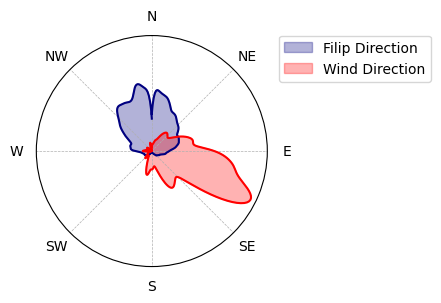

'/Users/filippomichelon/Documents/PersonalCode-local-utils/patagonia-trip-utils/garmin_patagonia_plots/smoothed_wind_direction_and_bearing.png'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

bearing = df['bearing']   # Adjust to wind origin
angles = (weather_data_combined['winddirection_10m'] + 180) % 360  # Adjust to wind origin

# Ensure 'bearing' and 'angles' are numeric NumPy arrays
bearing = np.array(bearing, dtype=float)
angles = np.array(angles, dtype=float)

# Convert degrees to radians
bearing_rad = np.radians(bearing)
angles_rad = np.radians(angles)

# Compute KDE for smoothing
bearing_kde = gaussian_kde(bearing_rad, bw_method=0.02)  # Adjust bandwidth for smoothness
angles_kde = gaussian_kde(angles_rad, bw_method=0.08)

# Generate points in [0, 2π] for smooth curve
theta = np.linspace(0, 2 * np.pi, 360)
bearing_density = bearing_kde(theta)
angles_density = angles_kde(theta)

# Normalize densities to percentage scale
bearing_density = (bearing_density / bearing_density.sum()) * 100
angles_density = (angles_density / angles_density.sum()) * 100

# Create polar plot
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'})

# Set North (0°) at the top and make the direction clockwise
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Define cardinal directions
cardinal_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
cardinal_positions = np.radians([0, 45, 90, 135, 180, 225, 270, 315])

ax.set_xticks(cardinal_positions)
ax.set_xticklabels(cardinal_labels)

# Make the grid smaller and finer
ax.grid(True, linestyle='--', linewidth=0.5)  # Dotted grid lines for better visibility

# Plot smoothed KDE curves and fill the area
ax.fill(theta, bearing_density, label="Filip Direction", color='navy', alpha=0.3)  # Fill with transparency
ax.fill(theta, angles_density, label="Wind Direction", color='red', alpha=0.3)  # Fill with transparency

# Draw boundary lines for better visibility
ax.plot(theta, bearing_density, color='navy', linewidth=1.5)
ax.plot(theta, angles_density, color='red', linewidth=1.5)
# Set y-axis ticks to only show 1 (100%)
ax.set_yticks([])
# Move the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


# Show the plot
plt.show()
# Save the plot to the specified directory
#save_path = '/Users/filippomichelon/Documents/PersonalCode-local-utils/patagonia-trip-utils/garmin_patagonia_plots/smoothed_wind_direction_and_bearing.png'
#fig.savefig(save_path, dpi = 500, bbox_inches='tight')  # Save the plot with tight layout to avoid clipping
#save_path